In [1]:
# Import neccessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error

In [ ]:
# Load training data
data = np.load('P-1.npy')

# Display first 5 data
data[:5]

In [3]:
np.isnan(data).sum()

np.int64(0)

In [4]:
np.min(data)

np.float64(-1.0)

In [5]:
np.max(data)

np.float64(1.0)

In [6]:
data.shape

(2872, 25)

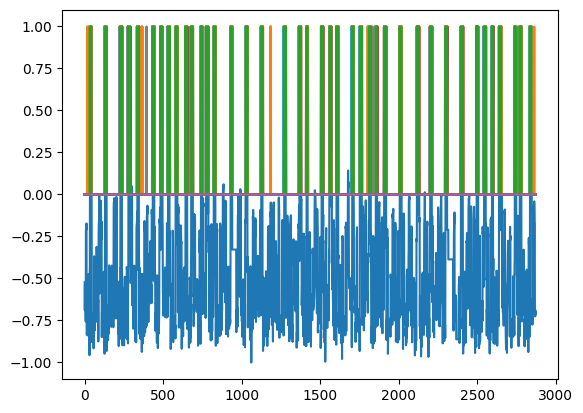

In [7]:
plt.plot(data)
plt.show()

In [8]:

series = pd.Series(data[0])
result = adfuller(series.values)
print(f'result: {result[0]}')
print(f'p-value: {result[1]}')

result: -2.0597925422169916e+16
p-value: 0.0


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


In [9]:
# Load test data
test_data = np.load('P-1_test.npy')

# Display first five test data
test_data[:5]

array([[-0.69516194,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.68570386,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.72571851,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0

In [10]:
# ls defines the number of periods used to predict the value
# lp defines the number of timesteps to predict
ls = 250
lp = 1
X = []
y = []
for i in range(0, len(data)-ls, 1):
  input = data[i: i+ls]
  output = data[i+ls, 0]
  X.append(input)
  y.append(output)
  #print(f"input: {input}, output: {output}")

In [11]:
# Convert training data to a numpy array
X_train = np.array(X)
X_train.shape

(2622, 250, 25)

In [12]:
# Convert predicted values to a numpy array
y_train = np.array(y)
y_train.shape

(2622,)

In [13]:
# Create sequences for test data
M = []
n = []
for i in range(0, len(test_data)-ls, 1):
  input = test_data[i: i+ls]
  output = test_data[i+ls, 0]
  M.append(input)
  n.append(output)

In [14]:
# Convert test data to a numpy array
X_test = np.array(M)
X_test.shape

(8255, 250, 25)

In [15]:
# Convert test data to a numpy array
y_test = np.array(n)
y_test.shape

(8255,)

In [72]:
# Define the model
model = keras.Sequential([
    LSTM(250, return_sequences=True, input_shape= (X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(80, return_sequences=True),
    Dropout(0.3),
    LSTM(80, return_sequences=False),
    Dropout(0.3),
    Dense(1, activation = 'linear')
]
)
# Display model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 250, 250)       │       276,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 250, 250)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 250, 80)        │       105,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 250, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 80)             │        51,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,521 (1.65 MB)

 Trainable params: 433,521 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Compile the model
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [19]:
# Set earlystopping
earlystopping = EarlyStopping(monitor='val_loss', patience=5)

In [20]:
# Train the model
history = model.fit(X_train, y_train, epochs = 100, validation_split= 0.2, batch_size = 64, callbacks=[earlystopping])

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - loss: 0.1607 - mae: 0.3310 - val_loss: 0.1055 - val_mae: 0.2664
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - loss: 0.0856 - mae: 0.2425 - val_loss: 0.0832 - val_mae: 0.2330
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - loss: 0.0726 - mae: 0.2186 - val_loss: 0.0676 - val_mae: 0.2152
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - loss: 0.0602 - mae: 0.1985 - val_loss: 0.0625 - val_mae: 0.2035
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - loss: 0.0537 - mae: 0.1847 - val_loss: 0.0629 - val_mae: 0.2015
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - loss: 0.0511 - mae: 0.1834 - val_loss: 0.0589 - val_mae: 0.1923
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - loss: 0.0489 - mae: 0.1764 - val_loss: 0.0602 - val_mae: 0.1935
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - loss: 0.0476 - mae: 0.1745 - val_loss: 0.0559 - val_mae: 0.1872
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - loss: 0.046

In [86]:
# Predictiion on test data
y_hat = model.predict(X_test)
y_hat

258/258 ━━━━━━━━━━━━━━━━━━━━ 105s 406ms/step


array([[0.02019956],
       [0.0203454 ],
       [0.01998863],
       ...,
       [0.01616345],
       [0.01857805],
       [0.02196109]], dtype=float32)

In [87]:
# Average absolute error between actual and predicted values

err  = mean_absolute_error(y_test ,y_hat)
err *100

53.32033794449337

In [88]:
# Create a list containing errors
e = []
j = 0
for i in y_test:
  e_t = np.abs(i - y_hat[j])
  j = j+1
  e.append(e_t)

In [89]:
# Smoothing errors
h = 2100
alpha = 0.005
e_s= []
for i in range(0, len(e)):
  ewma = alpha * e[i] + (1-alpha) * e[i-1]
  e_s.append(ewma)

In [90]:
# Calculate mean and standard deviation
mu_es = np.mean(e_s)
sigma_es = np.std(e_s)
print(f"Mean of smoothed error: {mu_es:.2f}")
print(f"Standard deviation of smoothed error: {sigma_es:.2f}")

Mean of smoothed error: 0.53
Standard deviation of smoothed error: 0.26


In [91]:
# Create a list of values
Z = set([2.0])
z = []
for i in Z:
  if i > mu_es:
    z.append(i)

In [92]:
# Find continuous anomaly sequences
max_epsilon = -12345679
Ea = []
Eseq = []
Nominal = []
for i in z:
  epsilon = mu_es + i * sigma_es
  print(f"Epsilon: {epsilon:.2f}")
  ea = [] # boolean
  e_a  =[] # anomaly array
  nominal = []
  eseq = []
  timestamp = []
  for j in range(0, len(e_s), 1):
    if e_s[j] > epsilon:
      #ea.append(True)
      e_a.append(e_s[j])
      timestamp.append(j)
      #print(f"Anomaly: {ea}")
    else:
      nominal.append(j)
  print("Len: ", len(e_a))
  #prev = e_a[0]
  eseq = []
  for k in range(0, len(e_a), 1):
    curr = e_a[k]
    if curr in e_a :
      eseq.append(e_a[k])
    elif curr not in e_a:
      nominal.append(curr)
  del_mu = mu_es - np.mean(nominal)
  del_sigma = sigma_es - np.std(nominal)

  try:
    max_epsilon = ((del_mu / mu_es) / (del_sigma - sigma_es)) / (len(e_a) + (len(eseq))**2)
  except (ZeroDivisionError, ValueError) as e:
    print("Error", e)
  if epsilon > max_epsilon:
    max_epsilon = epsilon
    Ea = ea
    Eseq = eseq
    print(f"Max Epsilon: {max_epsilon}")

Epsilon: 1.04
Len:  0


/tmp/ipython-input-4204727900.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  max_epsilon = ((del_mu / mu_es) / (del_sigma - sigma_es)) / (len(e_a) + (len(eseq))**2)


In [93]:
# Length of sequences
len(Eseq)

0

In [43]:
# Convert to an array
Eseq = np.array(Eseq, ndmin=1)
Eseq.shape

(456, 1)

In [94]:
# Provide severity score to a anomalous sequence
e_max = []
for i in Eseq:
  emax = max(i)
  e_max.append(emax)
  score = (emax - max_epsilon) / (mu_es + sigma_es)
  print(f"Anomaly: {emax}, Anomaly score: {score:.2f}")

In [51]:
# Sort in Descending order
e_max.sort(reverse=True)
e_max.append(np.max(nominal))

In [53]:
len(e_max)

458

In [55]:
# Determine final anomalous sequence
p = 0.13
for i in range(1, len(Eseq), 1):
  prev = e_max[i-1]
  curr = e_max[i]
  d = (e_max[i-1] - e_max[i]) / e_max[i-1]
  if d > p:
    for j in e_max:
      if j not in Ea:
        Ea.append(j)
  else:
    for j in e_max:
      if j not in Nominal:
        Nominal.append(j)



In [ ]:

label = pd.read_csv('labeled_anomalies.csv')
label.head()